<a href="https://colab.research.google.com/github/RiccardoSalvatori/amazon-phone-reviews/blob/master/Sentiment_Analisys_on_Smartphones_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis a livello di	frase	e	feature in ambito Smartphones

## Introduzione

Scopo di questo progetto è quello di effettuare uno studio di sentiment analysis a livello di feature in ambito smartphones partendo da recensioni scritte in testo libero dagli utenti di Amazon.com.

Sono state scelte caratteristiche comuni a tutti gli smartphones e, per ognuna di esse è stato determinato  una _score_ compreso tra 1 e 5 che ne descrive la bontà espressa dagli utenti.

Le feature prese in considerazione sono le seguenti:

*   Fotocamera 
    
*   Schermo 
    
*   Batteria 
*   Usabilità 
*   Rapporto qualità/prezzo 

Per valutare  la correttezza dei risultati ottenuti è stato utilizzato il test chi quadro confrontando i valori reperibili su Amazon.com con quelli ottenuti dall'analisi.





Installazione delle librerie necessarie

In [ ]:

if(!require("gridExtra")){
  install.packages("gridExtra")
} 
if(!require("dplyr")){
  install.packages("dplyr")
} 

if(!require("plyr")){
  install.packages("plyr")
} 

if(!require("ggplot2")){
  install.packages("ggplot2")
} 

if(!require("repr")){
  install.packages("repr")
} 

if(!require("stringr")){
  install.packages("stringr")
} 

library("gridExtra")
library("dplyr")
library("ggplot2")
library("stringr")
library("plyr")
library("repr")
options(repr.plot.width=20, repr.plot.height=8)


Loading required package: gridExtra

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘gridExtra’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: plyr

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘plyr’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: ggplot2

Loading required package: repr

Loading required package: stringr


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


--------------------------------------------

##Dataset


### Definizione

Il dataset utilizzato in questo progetto può essere liberamente scaricato dal seguente sito: https://data.world/promptcloud/amazon-mobile-phone-reviews e
conta oltre 400'000 recensioni di aquirenti estratte nel Dicembre 2016 da Amazon.com, categoria _'unlocked mobile'_ .
Per ogni recensione vengono indicati:


1.   Product.Name
    <br> _Nome completo del prodotto (e.g. Galaxy S7 Active SM-G891A Unlocked GSM 32GB Sandy Gold)_
2.   Brand.Name
    <br> _Marca del prodotto (e.g Samsung)_
3.   Price
    <br> _Prezzi in dollari_
4.   Rating
    <br> _Valutazione globale del prodotto data dall'autore della recensione_
5.   Reviews
    <br> _Testo della recensione_
6.   Review.Votes
    <br> _Numero di utenti che hanno trovato la recensione utile_

Ai fini dell'analisi sono state utilizzate le colonne Product.Name e Reviews.






*   Download dell’opinion lexicon di Hu & Liu
*   Download del dataset

Scarica i file da dropbox.


In [ ]:
hu.liu.neg <-	readLines("https://dl.dropbox.com/s/wb9ex6gu2ffozy7/negative-words.txt?dl=1")		
print("negative words downloaded")

hu.liu.pos <-	readLines("https://dl.dropbox.com/s/7v9jalu1bloxjub/positive-words.txt?dl=1")	
print("positive words downloaded")

mobile_reviwes	<-	read.csv("https://dl.dropbox.com/s/l26d4jfoqf8o4kc/amazon_mobile_reviwes.csv?dl=1")	
print("mobile reviwes downloaded")


[1] "negative words downloaded"
[1] "positive words downloaded"
[1] "mobile reviwes downloaded"


In [ ]:
 #mantiene solamente le colonne relative al nome del prodotto e alla recensione
 mobile_reviwes <- mobile_reviwes[,-c(2, 3, 4, 6)] 

## Pre-process

### Aggiunta di parole positive e negative nel contesto smartphones

Per determinare la polarità si una frase sono state utilizzate due liste di termini inglesi negativi e positivi.
Per migliorare la qualità dei risultati sono state aggiunte parole positive e negative specifiche per l'ambito smartphones.

In [ ]:
pos.words	=	c(hu.liu.pos, "thin", "slight", "responsive")	
neg.words	=	c(hu.liu.neg, "heavy", "thick", "hot", "unresponsive")

###Funzioni di utilità

La funzione _split_review_ permette di costruire la lista di frasi a partire dal una recensione.
Si è scelto di individuare le frasi come insieme di parole separate da:


*   Punteggiatura: '!' - '?' - ',' -  ';' - '-' - '.'
*   Congiunzioni: 'and' - 'or' - 'but' - 'nor' - 'for'



In [ ]:
#funzione di utilità per la stampe di logging
logger.log <- function(x,...) print(paste(x, ..., sep = ""))

#ritorna una lista di parole a partire da una frase contente spazi
split_sentence <- function(sentence){
  sentence	=	gsub('[^A-z ]','',	sentence)
  sentence	=	tolower(sentence)
  word.list	=	str_split(sentence,	'\\s+')
  return(unlist(word.list)	)
}

#ritorna una lista di frasi a partire da una recensione
split_review <- function(review){
  
  edit_review <- gsub("\\!+",".", review)
  edit_review <- gsub("\\?+",".",edit_review)
  edit_review <- gsub("\\,+",".",edit_review)	
  edit_review <- gsub("\\;+",".",edit_review)	
  edit_review <- gsub("\\-+",".",edit_review)	

  edit_review <- gsub(" and ",".",edit_review)
  edit_review <- gsub(" or ",".",edit_review)
  edit_review <- gsub(" but ",".",edit_review)	
  edit_review <- gsub(" for ",".",edit_review)
  edit_review <- gsub(" nor ",".",edit_review)

  #	suddividiamo	ogni	recensione	in	una	lista,	tramite	split	per	“.”	
  edit_review <- strsplit(edit_review,"\\.")

  return(edit_review)
}

Esempio di utilizzo di _split_review_

In [ ]:

splitted_review <- split_review("It's battery life is great. It's very responsive to touch. 
The only issue is that sometimes the screen goes black and you have to press the top button several times to get the screen to re-illuminate.")
print(splitted_review)
for(s in splitted_review)
  print(split_sentence(s))

[[1]]
[1] "It's battery life is great"                                            
[2] " It's very responsive to touch"                                        
[3] " \nThe only issue is that sometimes the screen goes black"             
[4] "you have to press the top button several times to get the screen to re"
[5] "illuminate"                                                            

 [1] "its"        "battery"    "life"       "is"         "great"     
 [6] ""           "its"        "very"       "responsive" "to"        
[11] "touch"      ""           "the"        "only"       "issue"     
[16] "is"         "that"       "sometimes"  "the"        "screen"    
[21] "goes"       "black"      "you"        "have"       "to"        
[26] "press"      "the"        "top"        "button"     "several"   
[31] "times"      "to"         "get"        "the"        "screen"    
[36] "to"         "re"         "illuminate"


### Valutazione del sentimento

Per analizzare il sentimento sulle feature si è deciso di utilizzare un approccio a livello di frase.
La polarità positiva, negativa o neautra viene determinata con uno score calcolato come sottrazione del numero di occorrenze di parole positive e negative.
Si considera neutra una recensione che ha score uguale a 0.  

In [ ]:
#funzione per calcolare lo score considerando la lista di parole positive e negative
score.featuresentiment.posneg	=	function(sentences,	feature,	pos.words, neg.words,	.progress='none'){
  #	in	score	verrà	salvato	l’output	della	funzione	seguente.	Ovvero	una	lista	dei	
  #punteggi	di	ogni	sentence	in	sentences
  scores	=	laply(sentences,	function(sentence,	feature,	pos.words,	neg.words)	{
    words	=	split_sentence(sentence)	
    #	valutiamo	se la	frase	contiene	una	delle	feature words
    feat.matches	=	match(words,	feature) 			
    score=0	#	il	punteggio	alla	feature	è	dato dalla	somma	dei	punteggi	delle	frasi	
    for(m	in	feat.matches){
      if(!is.na(m)){ 							
        #	Confrontiamo	le	parole	con	i	dizionari	dei	termini	positivi	e	negativi	
        pos.matches	=	match(words,	pos.words)	 			
        neg.matches	=	match(words,	neg.words) 			
        pos.matches	=	!is.na(pos.matches) 			
        neg.matches	=	!is.na(neg.matches)	
        score	=	sum(pos.matches) -	sum(neg.matches)	
      }
    }	
    return(score)	
  },	feature,	pos.words,	neg.words,	.progress=.progress	)
  scores.df	=	data.frame(score=scores,	text=sentences)	#	la	funzione	deve	ritornare,	
  #per	ogni	sentence	in	sentences,	il	testo	della	frase	e	il	punteggio	ottenuto	
  return(scores.df)	
}	

#calcola lo score per una feature nelle frasi passate in input
compute_score <- function(sentences, feature) {
  pos_neg_score <-  score.featuresentiment.posneg(sentences, feature, pos.words, neg.words)$score
  return(data.frame(score=pos_neg_score,	text=sentences))
}

###Definizione delle features

Le feature che si è deciso di prendere in considerazione sono le seguenti:
*   Fotocamera 
<br>_Qualità della fotocamera interna ed esterna dello smartphone. Nella valutazione di questa feature vengono considerate ad esmepio: la qualità delle foto, del flash, i megapixel..._
    
*   Schermo 
<br>_Qualità dello schermo. Rientrano in questa feature anche opionini relative alla bontà del touchscreen_

    
*   Batteria 
<br>_Qualità della batteria. Si valutano autonomia, tempo di caricamento e anche i connettori_ 
*   Usabilità 
<br>_La feature di usabilità riassume la facilità di utilizzo dello smartphone. Si considera ad esempio il peso, la reattività, la qualità dell' audio e dei bottoni_
*   Rapporto qualità/prezzo
<br> _Indice che indica quanto la soddisfazione degli utenti del prezzo pagato per lo smartphone. Viene valutato sulla base dei commenti che riguardano denaro e qualità_


Per ogni fetaure sono stati definiti dei sinonimi e delle parole ad essa correlate in maniera da estendere il dominio di commenti inerenti. 


In [ ]:
feature.camera <- c("camera", "photo", "photocamera", "megapixel", "mp", "selfie", 
                    "front", "back", "flash", "picture", "pic", "hdr", "video", 
                    "lens", "focal", "focus", "exposure",
                    "texture", "noise", "artifacts", "stabilization", "light",
                    "detection", "4k")

feature.screen <- c("screen", "display", "lcd", "inch",                     
                    "touchscreen", "led", "protection", "resolution", "tempered", "hd", 
                    "glass", "finger", "touch")

feature.battery <-c("battery", "life", "charge",  "charger", "duration", "charge time" , "autonomy",
                    "mah", "lithium", "power", "plug") 

feature.usability <- c("usability", "weight", "responsiveness", "performance", 
                       "os", "ios", "android", "water", "accessory", "material",
                       "processor", "durability", "handling" , "heat", "call", "audio", "mic", "sound",
                       "speed", "microphone", "speaker", "heaviness", "thickness", "fingerprint", "versatility", "wifi",
                       "internet","2g", "3g", "4g", "lte",
                       "sim", "dual-sim", "handling", "connection", "interface", "button", "usb"
                       )
feature.valueformoney <- c("price", "money", "value", "dollars", "pay", "quality")
                       

## Analisi 

In questo caso l'analisi si concentra su due smartphone in particolare: galaxy s7 e nexus 5 in quanto soggetti ad un elevato numero di recensioni e tra loro confrontabili in quanto usciti entrambi nel 2016.


In [ ]:
phones <- c("galaxy s7", "nexus 5")#, "huawei p9", "nexus 5", "iphone 7 plus", "oneplus") #smartphone 2016

###Funzione per il calcolo dello score per ogni feature per singolo smartphone.
In questa fase viene effettivamente calcolato lo **score** relativo ad ogni feature. Il punteggio è scalato in un valore tra 0 e 50 così da renderlo poi confrontabile con i valori presenti sul sito di Amazon.com.

Per prima cosa si filtra il dataset andando a selezionare le recensioni relative ad uno specifico smartphone: 
<br>
 `phone_name <- "nexus 5" \
 mobile_reviwes %>% filter(grepl(phone_name, tolower(Product.Name)))`

Vista la grande variabilità di nomi con cui viene indicato uno stesso smartphone, si cerca all'interno del testo nel campo `Product.Name` una qualsiasi sottostringa contenente `phone_name`. In questo modo prodotti come: _"Nexus 5 32Gb"_ e _"Nexus 5 64Gb"_ vengono considerati correttamente come relativi allo stesso telefono _"Nexus 5"_.

Le recensioni vengono in seguito suddivise :
<br>
` phone.text	<-	sapply(phone.reviwes ,	split_review,	simplify=F)`

Lo score per ogni feature viene dunque calcolato partendo dalle singole frasi.
La funzione `compute_score ` individua le sole frasi relative alla caratteristica considerata. Vengono selezionate infatti le sole frasi che contengono una o più parole correlate alla feature.
<br>
`feat.matches	=	match(words,	feature) `	

Lo score viene calcolato in questo modo:


*   #pos = numero totale di recensioni positive (score > 0)
*   #neg = numero totale di recensioni positive (score < 0 )



$$ 50 * \frac{\#pos}{\#pos + \#neg}  $$


In [ ]:
compute_phone <- function(phoneName){
 logger.log("computing ",phoneName, "...")

  #find reviwes for specific phone
  phone <- mobile_reviwes %>% filter(grepl(phoneName, tolower(Product.Name)))
  logger.log("total reviewes ->  ", length(phone$Reviews))
  
  phone.reviwes <- paste(phone$Reviews)

  #	suddividiamo	ogni	recensione	in	una	lista
  phone.text	<-	sapply(phone.reviwes ,	split_review,	simplify=F)	
  
  
  phone.sentences	<-	""	#	in	phone.sentences	avremo	la	lista	delle	frasi	
  for(s	in	phone.text){	#	ciclo	necessario	per	la	unlist	degli	elementi
    s.list=unlist(s)
    phone.sentences<-c(phone.sentences,s.list)	
  }
  
  logger.log("total sentences -> ", length(phone.sentences))
  
  
  phone.score.camera <- compute_score(phone.sentences, feature.camera)
  phone.score.camera$feature <- 'camera'
  
  phone.score.screen <- compute_score(phone.sentences, feature.screen)
  phone.score.screen$feature <- 'screen'
  
  phone.score.battery <- compute_score(phone.sentences, feature.battery)
  phone.score.battery$feature <- 'battery'
  
  phone.score.usability <- compute_score(phone.sentences, feature.usability)	
  phone.score.usability$feature <- 'usability'

  phone.score.valueformoney <- compute_score(phone.sentences, feature.valueformoney)	
  phone.score.valueformoney$feature <- 'valueformoney'
  return(list("camera" = phone.score.camera, 
              "screen" = phone.score.screen,
              "battery" = phone.score.battery, 
              "usability" = phone.score.usability,
              "valueformoney" = phone.score.valueformoney))
}
 

Analisi di feature su più smartphones

In [ ]:
phones.dfs <- list()
phone_scores <- list()
for(phoneName in phones){
  phone_scores[[phoneName]] <- compute_phone(phoneName)

  phone.all.scores	=	rbind(phone_scores[[phoneName]]$camera,	
                            phone_scores[[phoneName]]$screen,	
                            phone_scores[[phoneName]]$battery,
                            phone_scores[[phoneName]]$usability, 
                            phone_scores[[phoneName]]$valueformoney)	
  
  
  phone.all.scores$pos	=	as.numeric(	phone.all.scores$score > 0)	
  phone.all.scores$neg	=	as.numeric(	phone.all.scores$score < 0)	
  
  phone.scores.df	=	ddply(phone.all.scores,	c('feature'),	summarise, pos.count	=	sum(pos),	neg.count	=	sum(neg)	)	
  phone.scores.df$all.count	=	phone.scores.df$pos.count	+	phone.scores.df$neg.count	
  #	calcoliamo	il	punteggio	per	ogni	feature	(in	scala	da	0	a	50)	
  phone.scores.df$score	=	round(50 *	phone.scores.df$pos.count	/	phone.scores.df$all.count)	
 
  phone.scores.df$name = phoneName
  phones.dfs[[phoneName]] <- phone.scores.df 
  print(" ")
}
logger.log("complete")

[1] "computing galaxy s7..."
[1] "total reviewes ->  5920"
[1] "total sentences -> 35585"
[1] " "
[1] "computing nexus 5..."
[1] "total reviewes ->  6446"
[1] "total sentences -> 54360"
[1] " "
[1] "complete"


## Visualizzazione dei risultati



### Distribuzione dell'orientamento delle opinioni

Si selezionano le recensioni inerenti ad ogni singola feature e si graficano i valori di score in uno istogramma.

In [ ]:
feature_regex <- function(f) paste(f, collapse = "|")

plot_score_histograms <- function(phone_name){
  phone.df <- phone_scores[[phone_name]]
  
  df.battery <- phone.df$battery[grepl(feature_regex(feature.battery), phone.df$battery$text),]
  q1 <- qplot(df.battery$score, main = 'battery' )

  df.screen <- phone.df$screen[grepl(feature_regex(feature.screen), phone.df$screen$text),]
  q2 <- qplot(df.screen$score, main = 'screen' )


  df.camera <- phone.df$camera[grepl(feature_regex(feature.camera), phone.df$camera$text),]
  q3 <- qplot(df.camera$score, main = 'camera' )

  df.usability <- phone.df$usability[grepl(feature_regex(feature.usability), phone.df$usability$text),]
  q4 <- qplot(df.usability$score, main = 'usability' )

  df.valueformoney <- phone.df$valueformoney[grepl(feature_regex(feature.valueformoney), phone.df$valueformoney$text),]
  q5 <- qplot(df.valueformoney$score, main = 'valueformoney' )

  suppressMessages(grid.arrange(q1, q2, q3, q4, q5, nrow =2, ncol=3, top = phone_name))
}

#### Nexus 5

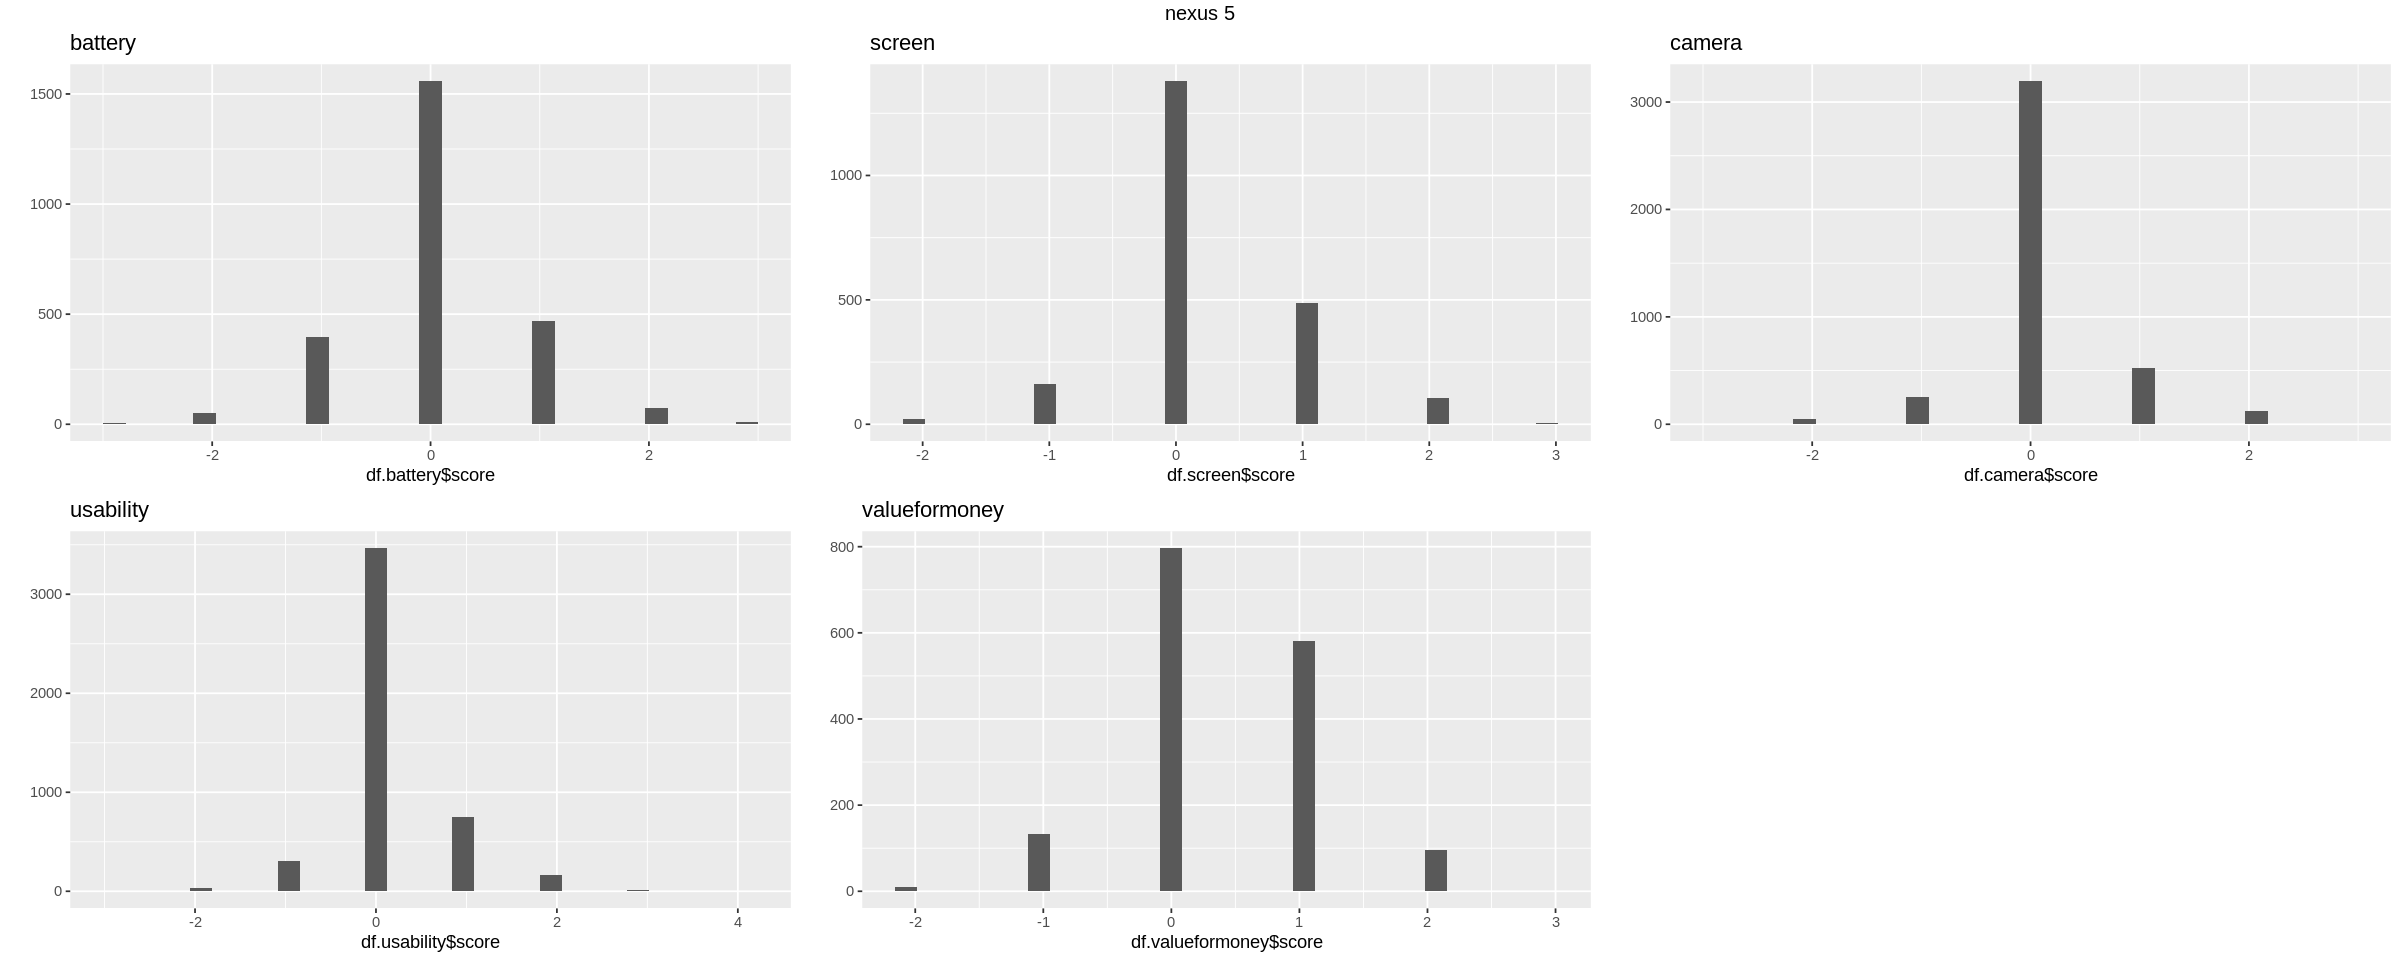

In [ ]:
plot_score_histograms("nexus 5")

#### Galaxy s7

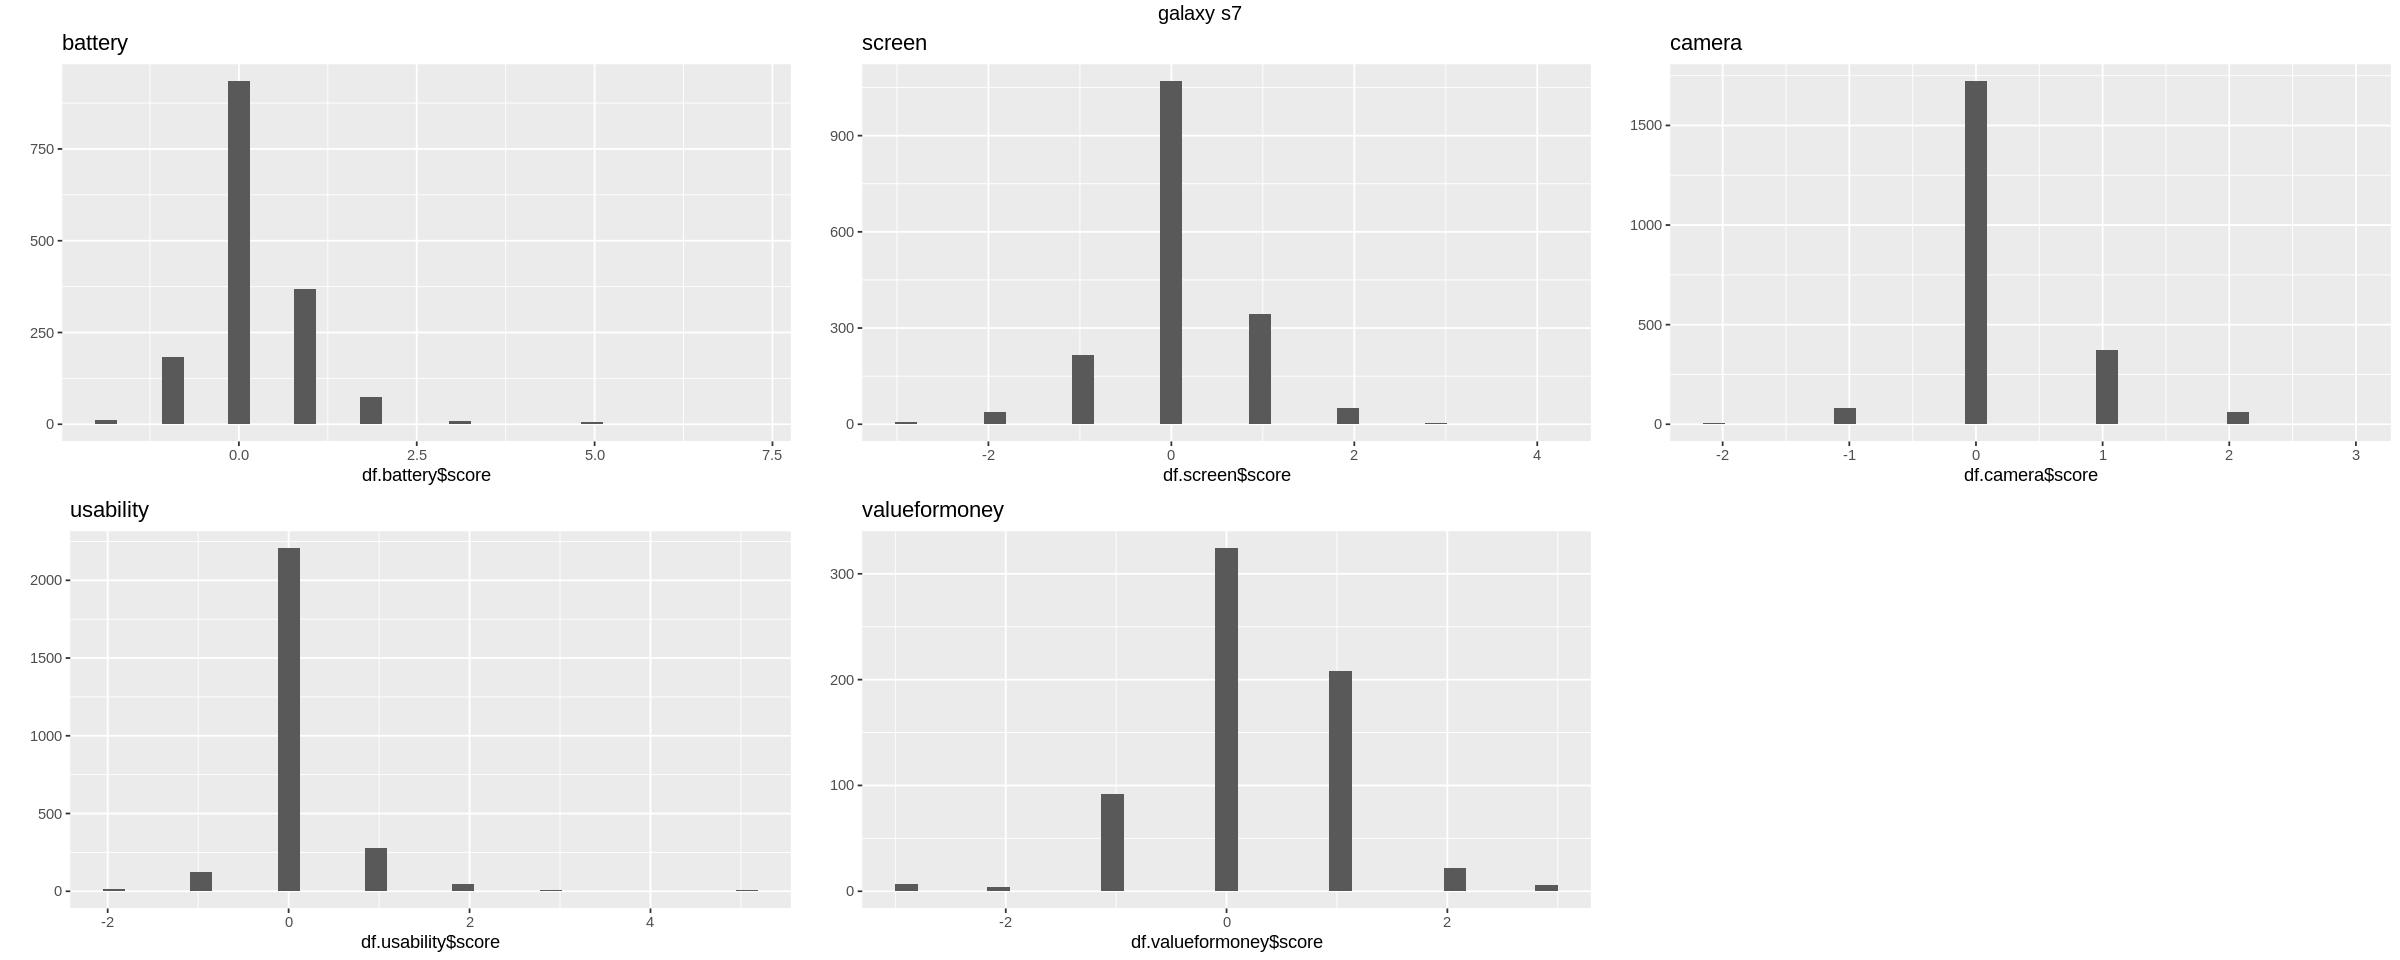

In [ ]:
plot_score_histograms("galaxy s7")

### Confronto delle valutazioni

Grafico a barre che permette di cofrontare i valori tra gli smartphones.

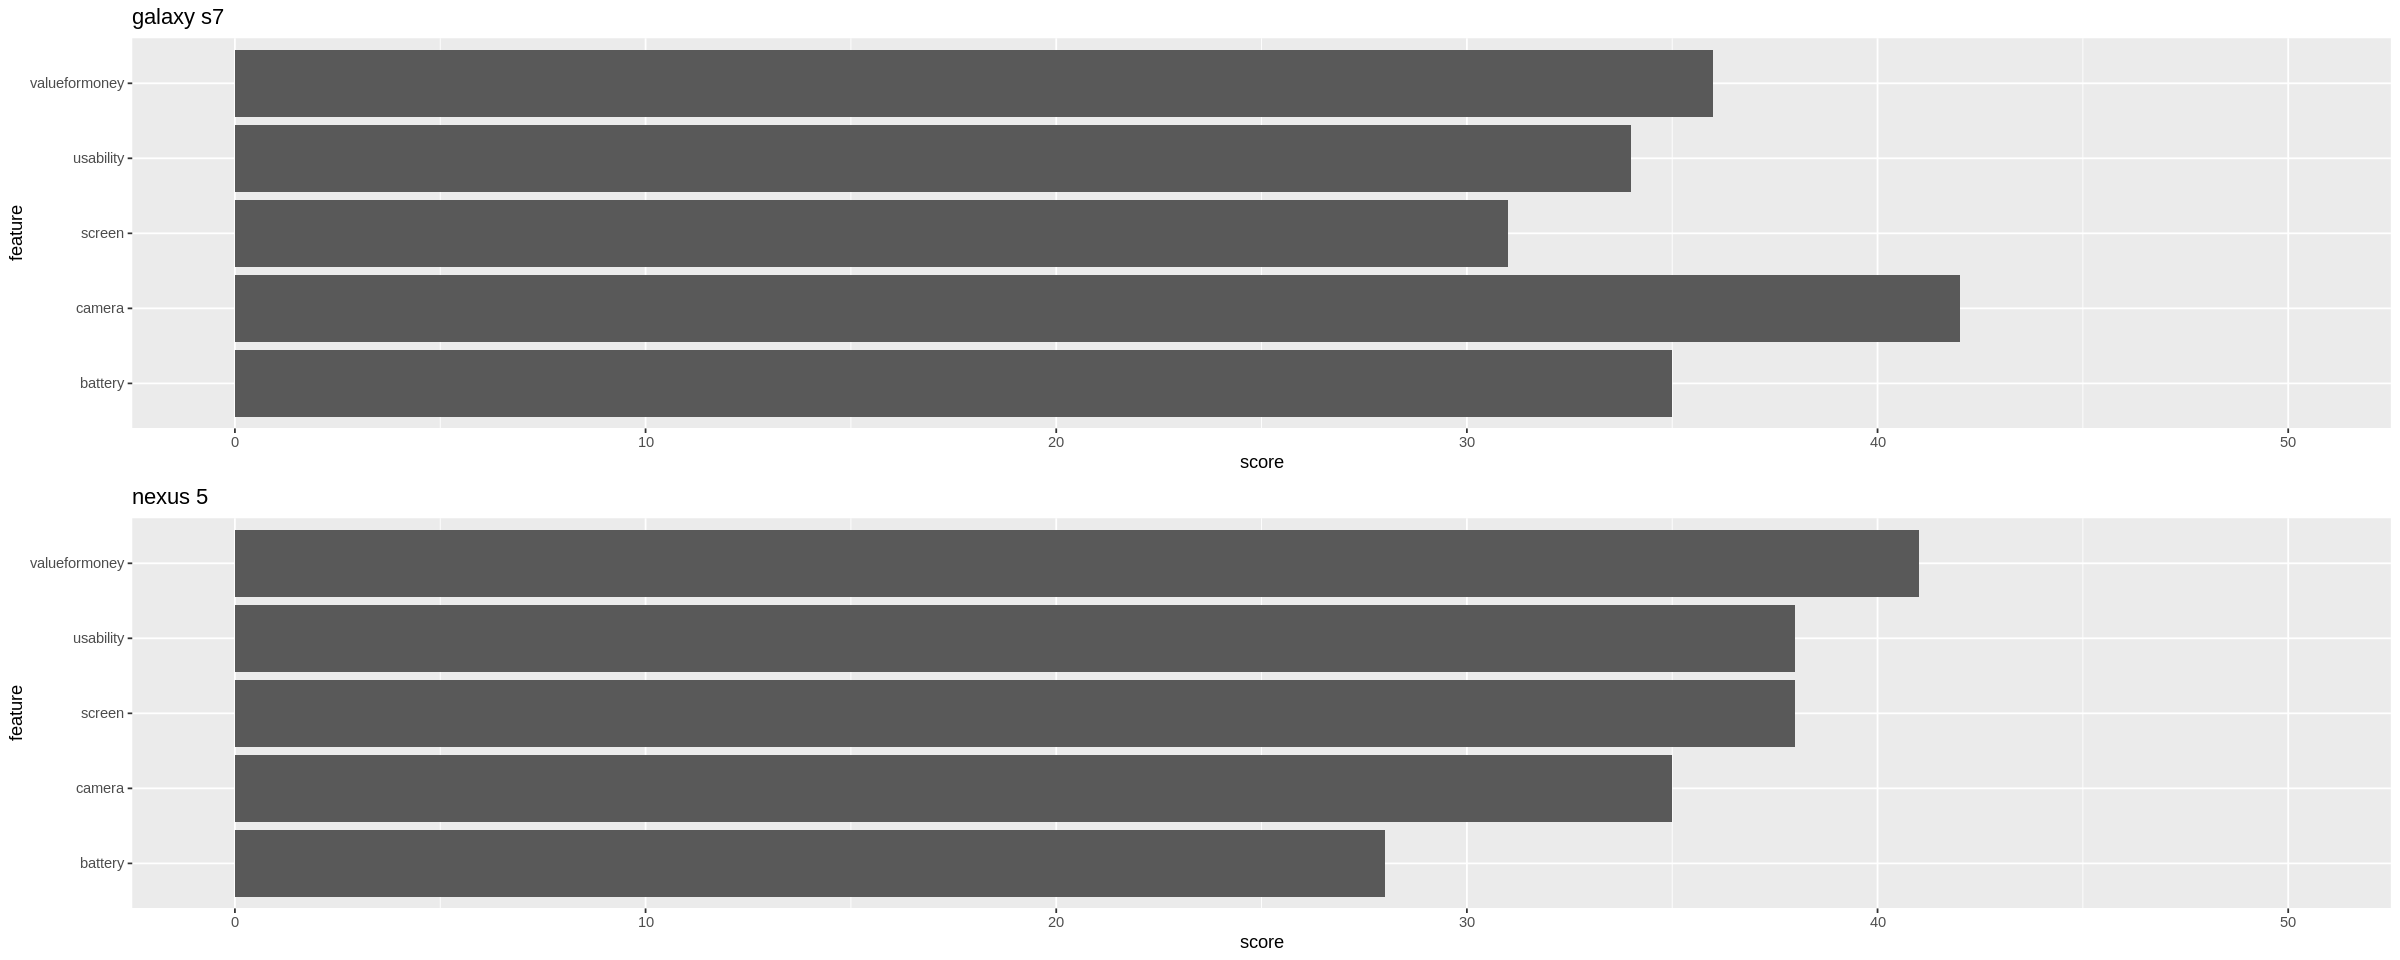

In [ ]:
l <- lapply(phones.dfs, function(p) ggplot(p, aes(x=feature, y=score)) + geom_bar(stat='identity') + coord_flip() + labs(title = p$name)+ ylim(0, 50))

size <- round(sqrt(length(phones)))
grid.arrange(grobs=l ,nrow = size+1, ncol = size)

## Valutazione dei risultati 

In questa fase vengono valutati i risultati confrontandoli  con quelli reperibili da Amazon.com tramite **test chi quadro**. 



#### Nexus 5

Valori calcolati come media delle feature messe a disposizione da Amazon.com:
 
Amazon:
*   Batteria -> 30
*   Fotocamera -> 37
*   Schermo -> 40
*   Usabilità -> 38
*   Qualità/Prezzo -> 29



##### Test chi quadro

Inseriamo in `actual` i valori calcolati mentre in `amazon` quelli per il confronto. 
L'ipotesi nulla è che la differenza tra i risultati `actual` e `amazon`
non sia significativa con livello di confidenza ≥ 0.95.

Risultato:

	Pearson's Chi-squared test
    X-squared = 2.1319, df = 4, p-value = 0.7115

Essendo il p-value > 0.05 (1-_confidenza_) la differenza non è significativa


	Pearson's Chi-squared test

data:  rbind(amazon$score, actual$score)
X-squared = 2.1319, df = 4, p-value = 0.7115



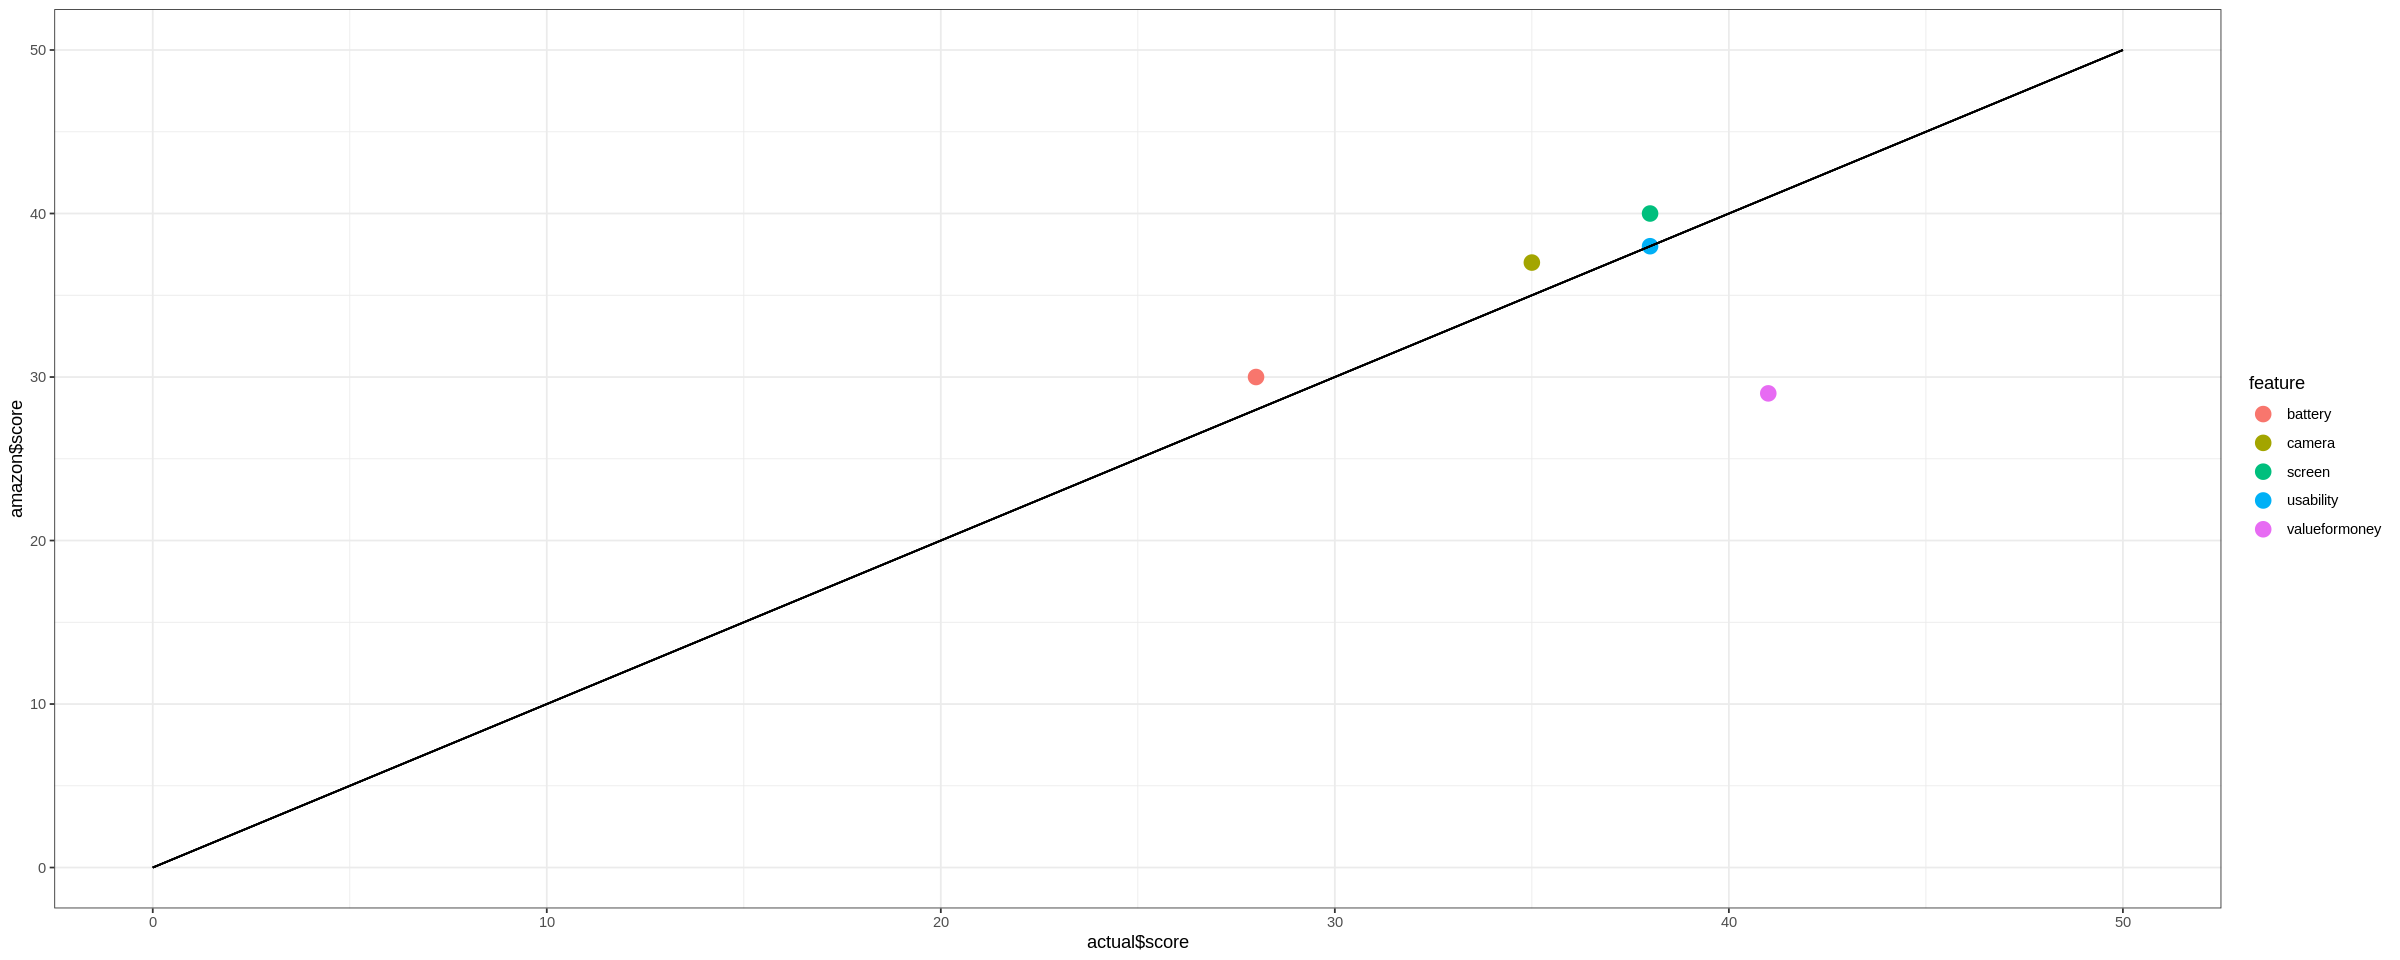

In [ ]:
# creiamo le due liste di valori da confrontare
actual <- phones.dfs[["nexus 5"]][c("score", "feature")]
amazon <- data.frame(score=c(30, 37, 40, 38, 29),	feature=c("battery", "camera", "screen", "usability", "valueformoney"))	
x <- chisq.test(rbind(amazon$score, actual$score), correct = TRUE)
print(x)
compare.df = merge(actual, amazon, by=c('feature'), suffixes=c('.actual', '.amazon'))
g.scatterr = ggplot( compare.df, aes(x=actual$score, y=amazon$score, ymin=30, ymax=50,xmin=30, xmax=50) ) + geom_point( aes(color=feature), size=4 ) + theme_bw() 
g.idd= g.scatterr + geom_segment(aes(x = 0, y = 0, xend =50, yend = 50))
print(g.idd)

#### Galaxy s7

Valori calcolati come media delle feature messe a disposizione da Amazon.com:
 
Amazon:
*   Batteria -> 37
*   Fotocamera -> 44
*   Schermo -> 42
*   Usabilità -> 40
*   Qualità/Prezzo -> 36

#####Test chi quadro
Ripetiamo il test anche su Galaxy s7.

Risultato:

    Pearson's Chi-squared test
    X-squared = 1.0797, df = 4, p-value = 0.8975

Essendo il p-value > 0.05 (1-confidenza) anche in questo caso la differenza non è significativa.




	Pearson's Chi-squared test

data:  rbind(amazon$score, actual$score)
X-squared = 1.0797, df = 4, p-value = 0.8975



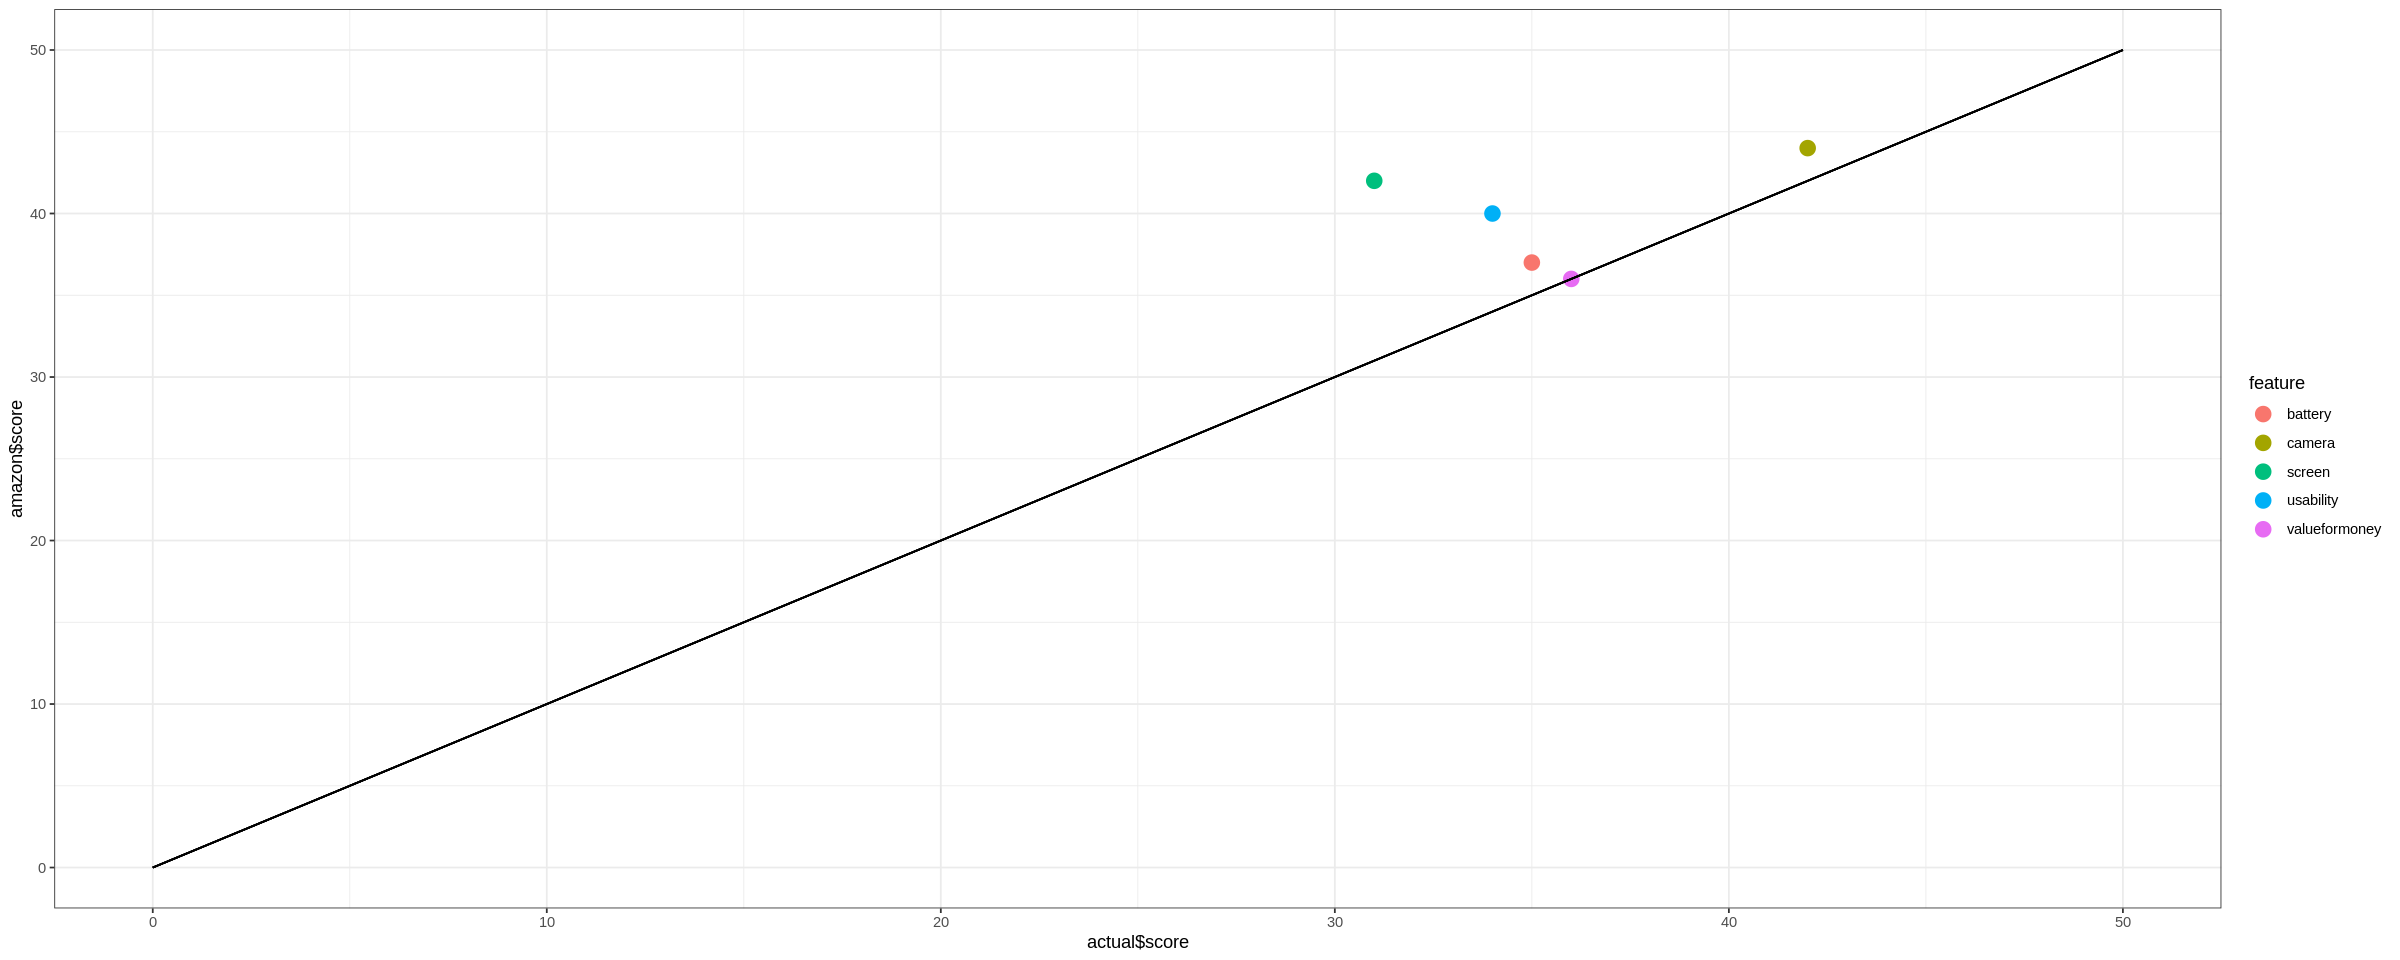

In [ ]:
actual <- phones.dfs[["galaxy s7"]][c("score", "feature")]
amazon <- data.frame(score=c(37,44,42,40, 36) ,	feature=c("battery","camera", "screen", "usability", "valueformoney"))
x <- chisq.test(rbind(amazon$score, actual$score), correct = TRUE)
print(x)
compare.df = merge(actual, amazon, by=c('feature'), suffixes=c('.actual', '.amazon'))
g.scatterr = ggplot( compare.df, aes(x=actual$score, y=amazon$score, ymin=30, ymax=50,xmin=30, xmax=50) ) + geom_point( aes(color=feature), size=4 ) + theme_bw() 
g.idd= g.scatterr + geom_segment(aes(x = 0, y = 0, xend =50, yend = 50))
print(g.idd)